In [22]:
import matplotlib.pyplot as plt
import numpy as np
from random import uniform
from shapely.geometry import Point, Polygon
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools

In [23]:
class CreateData:
    def __init__(self, points=1000):
        self.points = points

    def random_points(self, poly):
        minx, miny, maxx, maxy = poly.bounds
        while True:
            p = Point(uniform(minx, maxx), uniform(miny, maxy))
            if poly.contains(p):
                return p

    def polar_point(self, origin_point, angle,  distance):
        return [origin_point.x + math.sin(math.radians(angle)) * distance, origin_point.y + math.cos(math.radians(angle)) * distance]

    def sector(self, center, start_angle, end_angle, radius, steps=200):
        step_angle_width = (end_angle-start_angle) / steps
        sector_width = (end_angle-start_angle) 
        segment_vertices = []

        segment_vertices.append(self.polar_point(center, 0,0))
        segment_vertices.append(self.polar_point(center, start_angle,radius))

        for i in range(1, steps):
            segment_vertices.append((self.polar_point(center, start_angle + i * step_angle_width,radius)))
        segment_vertices.append(self.polar_point(center, start_angle+sector_width,radius))
        segment_vertices.append(self.polar_point(center, 0,0))
        return Polygon(segment_vertices)

    def create_samples_labels(self):
        polygons = [Polygon([(0, 0), (1, 0), (0, 1), (0, 0)]), Polygon([(0, 0), (-1, 0), (0, 1), (0, 0)]), 
                    Polygon([(0, 0), (-1, 0), (0, -1), (0, 0)]), Polygon([(0, 0), (1, 0), (0, -1), (0, 0)])]
        polygon_points = [[] for _ in polygons]

        for i in range(self.points):
            for j in range(len(polygons)):
                polygon_points[j].append(self.random_points(polygons[j]))

        center = Point(0,0)
        sectors = [self.sector(center, 0, 90, 1), self.sector(center, 0, -90, 1), self.sector(center, 180, 270, 1), self.sector(center, 180, 90, 1)]
        sector_points = [[] for _ in sectors]

        for i in range(self.points):
            for j in range(len(sectors)):
                sector_points[j].append(self.random_points(sectors[j].difference(polygons[j])))

        samples = []
        labels = []

        for i in range(self.points):
            for j in range(len(polygons)):
                samples.append([polygon_points[j][i].x, polygon_points[j][i].y])
                labels.append([int(k==j) for k in range(len(polygons))])
            for j in range(len(sectors)):
                samples.append([sector_points[j][i].x, sector_points[j][i].y])
                labels.append([int(k==j+len(polygons)) for k in range(len(polygons)+len(sectors))])

        max_sample_length = max(len(sample) for sample in samples)
        max_label_length = max(len(label) for label in labels)

        samples = [sample + [0]*(max_sample_length - len(sample)) for sample in samples]
        labels = [label + [0]*(max_label_length - len(label)) for label in labels]

        return np.array(samples), np.array(labels)

In [24]:
generator = CreateData(points=1000)
samples, labels = generator.create_samples_labels()

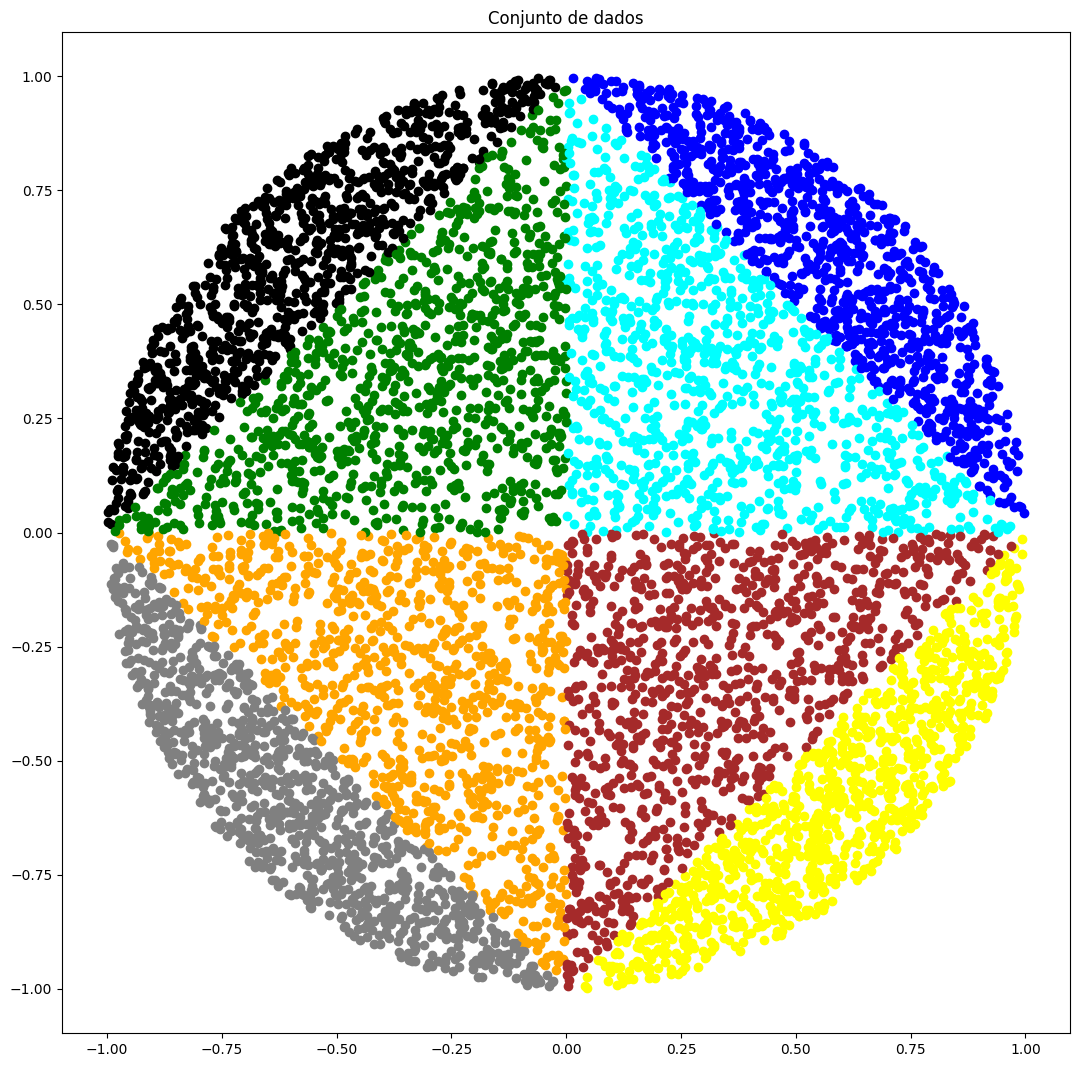

In [25]:
c1Points = samples[np.where(np.all(labels == [1, 0, 0, 0, 0, 0, 0, 0], axis=1))]
c2Points = samples[np.where(np.all(labels == [0, 1, 0, 0, 0, 0, 0, 0], axis=1))]
c3Points = samples[np.where(np.all(labels == [0, 0, 1, 0, 0, 0, 0, 0], axis=1))]
c4Points = samples[np.where(np.all(labels == [0, 0, 0, 1, 0, 0, 0, 0], axis=1))]
c5Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 1, 0, 0, 0], axis=1))]
c6Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 0, 1, 0, 0], axis=1))]
c7Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 0, 0, 1, 0], axis=1))]
c8Points = samples[np.where(np.all(labels == [0, 0, 0, 0, 0, 0, 0, 1], axis=1))]


plt.figure(figsize=(13,13))
plt.title('Conjunto de dados')
for i in range(generator.points):
    plt.scatter(c1Points[i, 0], c1Points[i, 1], color='cyan')
    plt.scatter(c2Points[i, 0], c2Points[i, 1], color='green')
    plt.scatter(c3Points[i, 0], c3Points[i, 1], color='orange')
    plt.scatter(c4Points[i, 0], c4Points[i, 1], color='brown')
    plt.scatter(c5Points[i, 0], c5Points[i, 1], color='blue')
    plt.scatter(c6Points[i, 0], c6Points[i, 1], color='black')
    plt.scatter(c7Points[i, 0], c7Points[i, 1], color='grey')
    plt.scatter(c8Points[i, 0], c8Points[i, 1], color='yellow')
plt.show()


In [26]:
train_samples, test_samples, train_labels, test_labels = train_test_split(samples, labels, test_size=0.1, random_state=45)

In [27]:
train_samples.shape
train_labels.shape

(7200, 8)

## Regra Delta Convencional

In [28]:
model_convencional = Sequential([
    Dense(units=16, input_shape=(2,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='softmax'),
])

In [29]:
model_convencional.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
result_convencional= model_convencional.fit(x=train_samples, y=train_labels, validation_split=0.2, batch_size=22, epochs=50, shuffle=True, verbose=2)

Epoch 1/50


262/262 - 2s - loss: 0.5815 - accuracy: 0.7859 - val_loss: 0.2786 - val_accuracy: 0.8757 - 2s/epoch - 6ms/step
Epoch 2/50
262/262 - 1s - loss: 0.2295 - accuracy: 0.9061 - val_loss: 0.1375 - val_accuracy: 0.9604 - 512ms/epoch - 2ms/step
Epoch 3/50
262/262 - 0s - loss: 0.1473 - accuracy: 0.9434 - val_loss: 0.1338 - val_accuracy: 0.9479 - 497ms/epoch - 2ms/step
Epoch 4/50
262/262 - 0s - loss: 0.1586 - accuracy: 0.9342 - val_loss: 0.1026 - val_accuracy: 0.9632 - 496ms/epoch - 2ms/step
Epoch 5/50
262/262 - 1s - loss: 0.1297 - accuracy: 0.9464 - val_loss: 0.1120 - val_accuracy: 0.9493 - 505ms/epoch - 2ms/step
Epoch 6/50
262/262 - 1s - loss: 0.1382 - accuracy: 0.9429 - val_loss: 0.2482 - val_accuracy: 0.9000 - 510ms/epoch - 2ms/step
Epoch 7/50
262/262 - 1s - loss: 0.1186 - accuracy: 0.9498 - val_loss: 0.1040 - val_accuracy: 0.9528 - 513ms/epoch - 2ms/step
Epoch 8/50
262/262 - 0s - loss: 0.1158 - accuracy: 0.9483 - val_loss: 0.0852 - val_accuracy: 0.9674 - 500ms/epoch - 2ms/step
Epoch 9/50
262

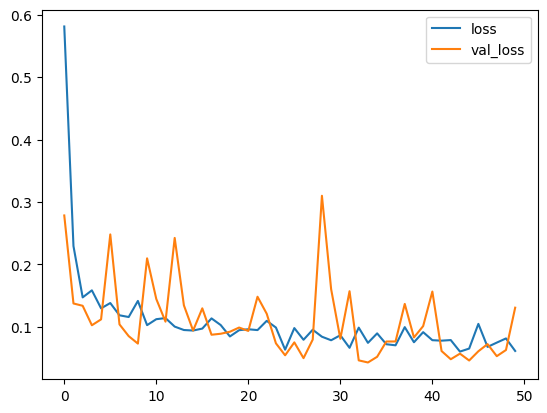

In [31]:
plt.plot(result_convencional.history['loss'], label='loss')
plt.plot(result_convencional.history['val_loss'], label='val_loss')
plt.legend()

In [32]:
predictions_convencional = model_convencional.predict(x=test_samples, batch_size=22,verbose=0)
rounded_predictions_convencional = np.argmax(predictions_convencional, axis=-1)
accuracy_score(rounded_predictions_convencional, np.argmax(test_labels, axis=-1))

0.94625

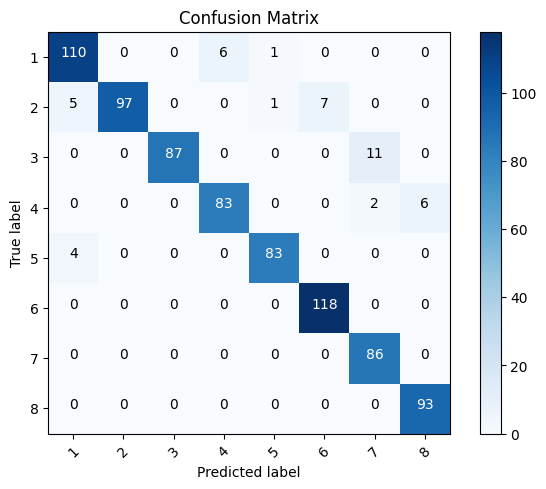

In [33]:
cm = confusion_matrix(np.argmax(test_labels, axis=-1), rounded_predictions_convencional)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()



## Regra Delta com Termo do Momento

In [34]:
model_momento = Sequential([
    Dense(units=16, input_shape=(2,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='softmax'),
])

In [35]:
model_momento.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
result_momento = model_momento.fit(x=train_samples, y=train_labels, validation_split=0.2, batch_size=22, epochs=50, shuffle=True, verbose=2)

Epoch 1/50
262/262 - 2s - loss: 0.5939 - accuracy: 0.7710 - val_loss: 0.2203 - val_accuracy: 0.9479 - 2s/epoch - 7ms/step
Epoch 2/50
262/262 - 1s - loss: 0.2028 - accuracy: 0.9222 - val_loss: 0.1785 - val_accuracy: 0.9278 - 605ms/epoch - 2ms/step
Epoch 3/50
262/262 - 0s - loss: 0.1981 - accuracy: 0.9156 - val_loss: 0.1302 - val_accuracy: 0.9576 - 457ms/epoch - 2ms/step
Epoch 4/50
262/262 - 1s - loss: 0.1525 - accuracy: 0.9384 - val_loss: 0.1215 - val_accuracy: 0.9493 - 550ms/epoch - 2ms/step
Epoch 5/50
262/262 - 1s - loss: 0.1369 - accuracy: 0.9444 - val_loss: 0.1067 - val_accuracy: 0.9521 - 574ms/epoch - 2ms/step
Epoch 6/50
262/262 - 1s - loss: 0.1419 - accuracy: 0.9392 - val_loss: 0.1702 - val_accuracy: 0.9222 - 592ms/epoch - 2ms/step
Epoch 7/50
262/262 - 0s - loss: 0.1222 - accuracy: 0.9500 - val_loss: 0.1108 - val_accuracy: 0.9472 - 412ms/epoch - 2ms/step
Epoch 8/50
262/262 - 1s - loss: 0.1297 - accuracy: 0.9451 - val_loss: 0.1490 - val_accuracy: 0.9340 - 556ms/epoch - 2ms/step
Epo

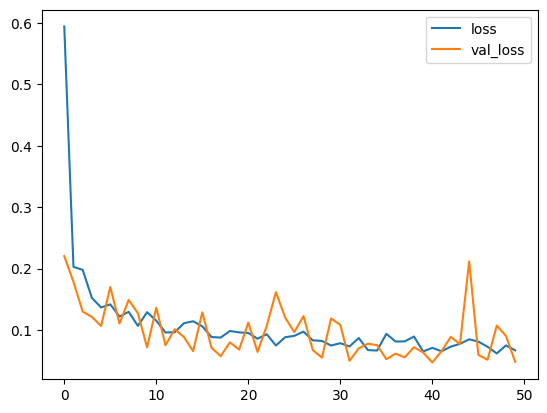

In [37]:
plt.plot(result_momento.history['loss'], label='loss')
plt.plot(result_momento.history['val_loss'], label='val_loss')
plt.legend()

In [38]:
prediction_momento = model_momento.predict(x=test_samples, batch_size=22,verbose=0)
rounded_prediction_momento = np.argmax(prediction_momento, axis=-1)
accuracy_score(rounded_prediction_momento, np.argmax(test_labels, axis=-1))

0.98375

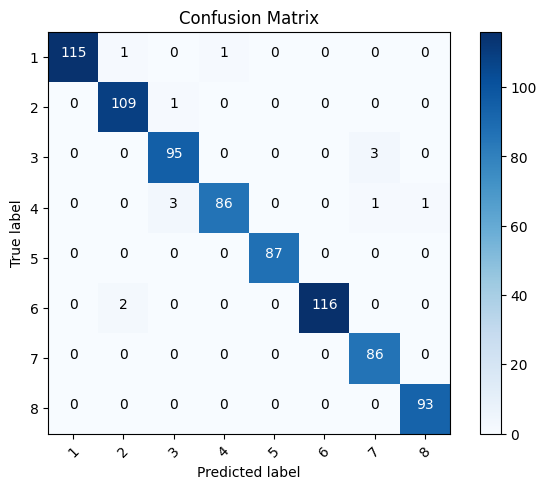

In [39]:
cm = confusion_matrix(np.argmax(test_labels, axis=-1), rounded_prediction_momento)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

plt.show()

